# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import datetime
import time
from IPython.display import clear_output

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from utils import *

from grace.utils import *

# Initialization

In [2]:
# Helper Functions

calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")

left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}
    
chessboard_size = (9,6)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    try:
        if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 0
        elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 1
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 2
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 3
    except:
        phi_direction = 0
    return phi_direction

def get_chess_corners(img, camera_mtx, dist_coef):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    # Subcorner Pixel Accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(gray, corners, (9,9), (-1,-1), criteria)
    corners = corners.squeeze()
    
    return corners

def get_chess_obj_pts(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]

    obj_pts = []
    for u,v in corners:
        z = depth_mean
        x = ((u-cx)/fx)*z
        y = ((v-cy)/fy)*z
        obj_pts.append([x, y, z])
        
    return np.array(obj_pts)

def get_depth_mean(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    return depth_mean

def get_camera_pose(img, obj_pts, camera_mtx, dist_coef):
    # Get corners
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    
    # Estimate the extrinsic matrix
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef)
    retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, flags=cv2.SOLVEPNP_SQPNP )
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, rvec, tvec=np.array([0,0,0.25]), useExtrinsicGuess = True)
    
    # Convert the rotation vector to a rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    
    # Homogeneous Coordinates
    H = np.eye(4)
    H[:3,:3] = rotation_matrix
    H[:3,-1] = tvec.T
    
    # Camera Pose
    T = np.linalg.inv(H)
    return T
    
def depth_to_pointcloud(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    if z==0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,y,z

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Loading of Data

## Pickle Data

In [3]:
filename = 'baseline_fk_acc_pickle_20240207_022613_505690.pickle'

In [4]:
fn_path = os.path.join(os.getcwd(), 'results', 'supervised_ml',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [5]:
pickle_df = pd.DataFrame(data)

## Preprocessing



In [6]:
# Assigning next step data for tminus1

pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()
pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

In [7]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [8]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_angle', 'plan_phi_left_pan', 'plan_phi_right_pan',
       'plan_phi_tilt', 'chest_img', 'left_eye_img', 'right_eye_img',
       'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'chest_pan_angle',
       'chest_tilt_angle', 'chess_idx_tminus1', 'theta_left_pan_tminus1',
       'theta_right_pan_tminus1', 'theta_tilt_tminus1',
       'plan_phi_left_pan_tminus2', 'plan_phi_right_pan_tminus2',
       'plan_phi_tilt_tminus2', 'plan_phi_left_pan_tminus1',
       'plan_phi_right_pan_tminus1', 'plan_phi_tilt_tminus1',
       

In [9]:
# Dropping the first row
pickle_df = pickle_df.drop(np.arange(0,8)).reset_index(drop=True)
pickle_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,7,-0.263672,-1.669922,-21.357422,413.390991,208.458206,318.888123,184.908112,190.799896,192.944504,...,-25.312500,0.086831,0.045774,-0.179524,-0.015795,-0.057006,-0.146185,2,2,1
1,18,4.921875,3.427734,-1.669922,507.542480,133.160950,359.454620,201.503403,203.791916,211.335052,...,-21.357422,-0.015795,-0.057006,-0.146185,0.150523,0.110172,-0.011876,1,1,3
2,48,-2.460938,-3.867188,-11.601562,375.845795,171.483841,318.125519,192.025558,190.825455,199.547363,...,-1.669922,0.150523,0.110172,-0.011876,-0.080395,-0.121296,-0.080592,2,2,2
3,17,0.175781,-1.142578,-25.312500,432.391083,227.324966,365.050720,189.645874,210.719406,198.496475,...,-11.601562,-0.080395,-0.121296,-0.080592,0.014797,-0.026303,-0.179524,1,1,0
4,43,5.976562,4.482422,-6.679688,526.551453,151.841431,359.279846,199.419418,204.303284,209.239883,...,-25.312500,0.014797,-0.026303,-0.179524,0.184000,0.144179,-0.045745,3,3,1


# Filtering

## Valid Chessboard Points

In [10]:
filt_df = pickle_df[pickle_df['dx_l']>-200].reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,7,-0.263672,-1.669922,-21.357422,413.390991,208.458206,318.888123,184.908112,190.799896,192.944504,...,-25.312500,0.086831,0.045774,-0.179524,-0.015795,-0.057006,-0.146185,2,2,1
1,18,4.921875,3.427734,-1.669922,507.542480,133.160950,359.454620,201.503403,203.791916,211.335052,...,-21.357422,-0.015795,-0.057006,-0.146185,0.150523,0.110172,-0.011876,1,1,3
2,48,-2.460938,-3.867188,-11.601562,375.845795,171.483841,318.125519,192.025558,190.825455,199.547363,...,-1.669922,0.150523,0.110172,-0.011876,-0.080395,-0.121296,-0.080592,2,2,2
3,17,0.175781,-1.142578,-25.312500,432.391083,227.324966,365.050720,189.645874,210.719406,198.496475,...,-11.601562,-0.080395,-0.121296,-0.080592,0.014797,-0.026303,-0.179524,1,1,0
4,43,5.976562,4.482422,-6.679688,526.551453,151.841431,359.279846,199.419418,204.303284,209.239883,...,-25.312500,0.014797,-0.026303,-0.179524,0.184000,0.144179,-0.045745,3,3,1


In [11]:
filt_df

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,7,-0.263672,-1.669922,-21.357422,413.390991,208.458206,318.888123,184.908112,190.799896,192.944504,...,-25.312500,0.086831,0.045774,-0.179524,-0.015795,-0.057006,-0.146185,2,2,1
1,18,4.921875,3.427734,-1.669922,507.542480,133.160950,359.454620,201.503403,203.791916,211.335052,...,-21.357422,-0.015795,-0.057006,-0.146185,0.150523,0.110172,-0.011876,1,1,3
2,48,-2.460938,-3.867188,-11.601562,375.845795,171.483841,318.125519,192.025558,190.825455,199.547363,...,-1.669922,0.150523,0.110172,-0.011876,-0.080395,-0.121296,-0.080592,2,2,2
3,17,0.175781,-1.142578,-25.312500,432.391083,227.324966,365.050720,189.645874,210.719406,198.496475,...,-11.601562,-0.080395,-0.121296,-0.080592,0.014797,-0.026303,-0.179524,1,1,0
4,43,5.976562,4.482422,-6.679688,526.551453,151.841431,359.279846,199.419418,204.303284,209.239883,...,-25.312500,0.014797,-0.026303,-0.179524,0.184000,0.144179,-0.045745,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389,4,-2.548828,-3.867188,-21.093750,375.573242,208.863983,319.851044,187.445358,192.000107,195.052490,...,-16.347656,0.115440,0.076104,-0.111932,-0.081507,-0.121268,-0.148061,2,2,2
5390,20,1.318359,0.000000,-2.021484,450.895325,133.693924,362.604950,198.630295,208.764343,207.594086,...,-21.093750,-0.081507,-0.121268,-0.148061,0.049232,0.010272,-0.014614,1,1,1
5391,43,-0.615234,-2.021484,-11.601562,413.415100,171.248703,327.673676,192.985596,197.672607,201.259583,...,-2.021484,0.049232,0.010272,-0.014614,-0.017239,-0.056652,-0.080495,2,2,2
5392,33,4.833984,3.251953,-20.742188,508.432861,208.235519,361.594543,193.386429,207.442612,203.107330,...,-11.601562,-0.017239,-0.056652,-0.080495,0.147906,0.108696,-0.145282,1,1,0


# Appending Data

In [12]:
filename = '20240308_3d_points_cmds.csv'

In [13]:
fn_path = os.path.join(os.getcwd(), 'results', 'supervised_ml',filename)
points_3d_df = pd.read_csv(fn_path)

In [14]:
points_3d_df.head()

,theta_l_pan_cmd,theta_tilt_cmd,gazepoint_x,gazepoint_y,gazepoint_z
0,-0.555946,-21.642892,0.082110,0.016291,1.514808
1,5.298153,-1.758292,0.211026,-0.214231,1.514808
2,-2.829763,-11.931707,-0.011784,-0.097580,1.514808
3,0.520836,-26.578723,0.008992,0.056656,1.514808
4,6.476497,-6.772669,0.259937,-0.161370,1.514808


# Plotting

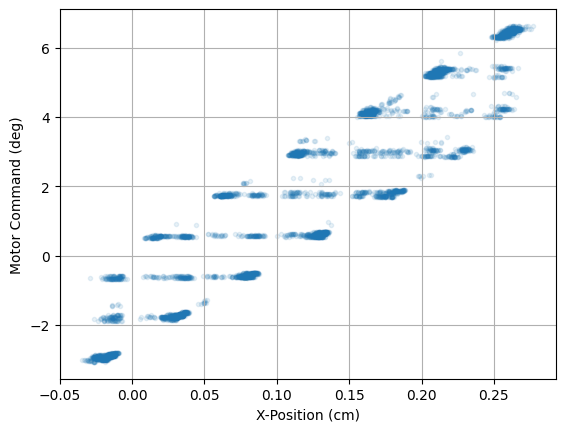

In [15]:
plt.scatter(points_3d_df['gazepoint_x'], points_3d_df['theta_l_pan_cmd'], marker='.', alpha=0.1)
plt.ylabel('Motor Command (deg)')
plt.xlabel('X-Position (cm)')
plt.grid()

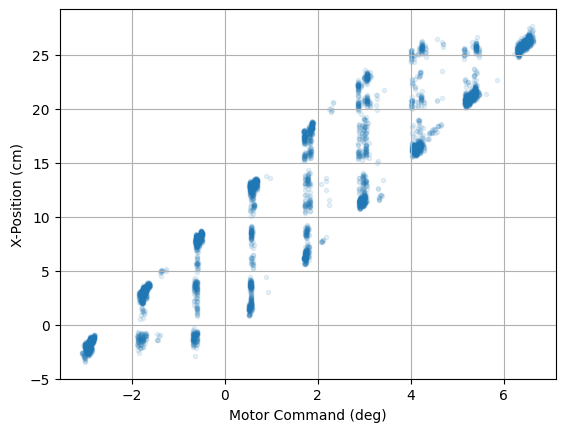

In [16]:
plt.scatter(points_3d_df['theta_l_pan_cmd'], 100*points_3d_df['gazepoint_x'], marker='.', alpha=0.1)
plt.xlabel('Motor Command (deg)')
plt.ylabel('X-Position (cm)')
plt.grid()

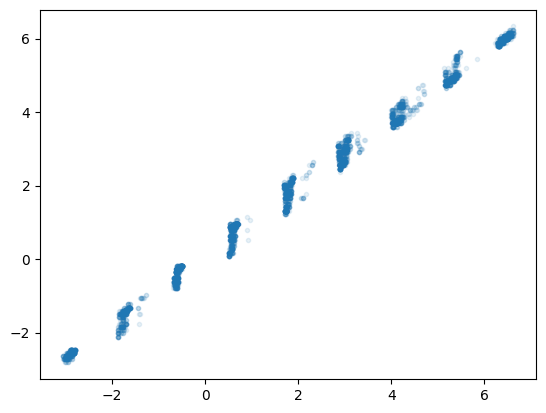

In [17]:
plt.scatter(points_3d_df['theta_l_pan_cmd'], filt_df['theta_left_pan'], marker='.', alpha=0.1)

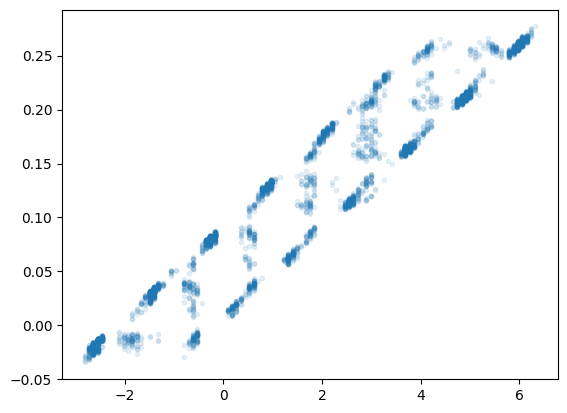

In [18]:
plt.scatter(filt_df['theta_left_pan'], points_3d_df['gazepoint_x'], marker='.', alpha=0.1)

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

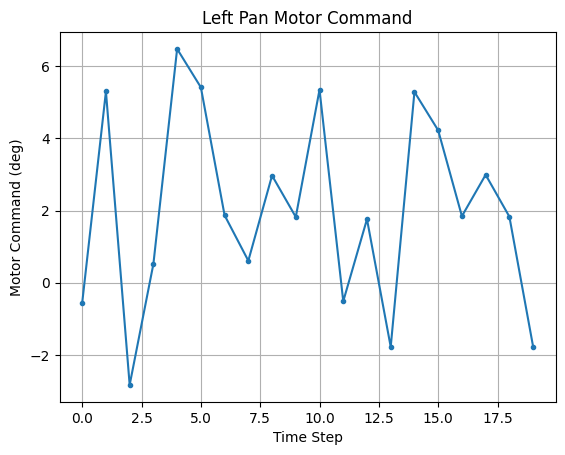

In [20]:
plt.plot(points_3d_df['theta_l_pan_cmd'][:20].values.reshape(-1, 1), marker='.', color=colors[0])
plt.xlabel('Time Step')
plt.ylabel('Motor Command (deg)')
plt.title('Left Pan Motor Command')
plt.grid()

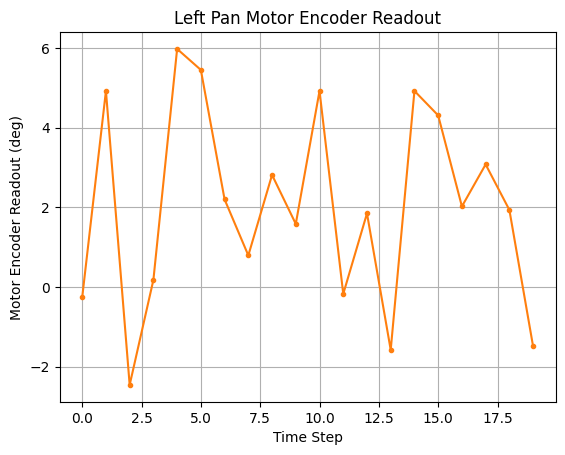

In [21]:
plt.plot(filt_df['theta_left_pan'][:20].values.reshape(-1, 1), marker='.', color=colors[1])
plt.xlabel('Time Step')
plt.ylabel('Motor Encoder Readout (deg)')
plt.title('Left Pan Motor Encoder Readout')
plt.grid()

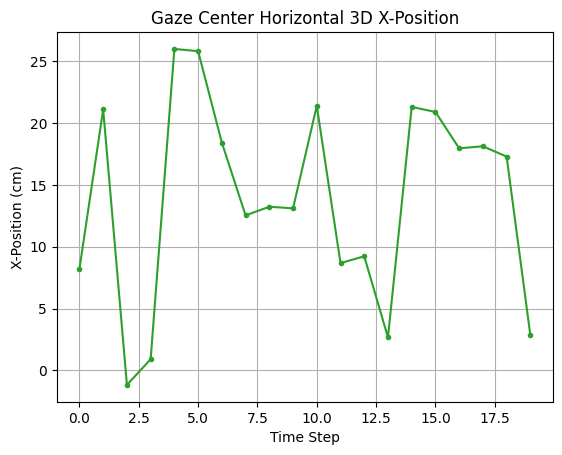

In [22]:
plt.plot(100*points_3d_df['gazepoint_x'][:20].values.reshape(-1, 1), marker='.', color=colors[2])
plt.xlabel('Time Step')
plt.ylabel('X-Position (cm)')
plt.title('Gaze Center Horizontal 3D X-Position')
plt.grid()

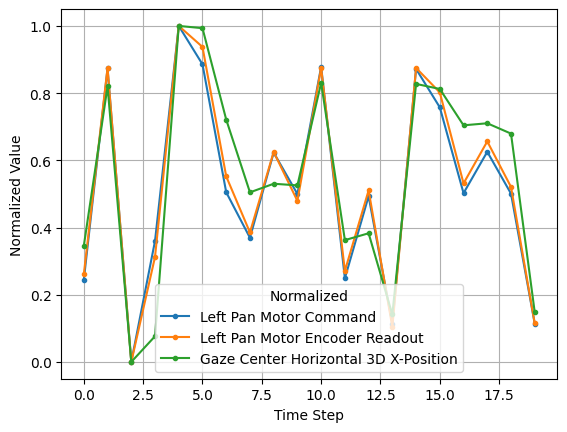

In [23]:
norm_gazepoint_x = scaler.fit_transform(points_3d_df['gazepoint_x'][:20].values.reshape(-1, 1))
norm_theta_l_pan_cmd = scaler.fit_transform(points_3d_df['theta_l_pan_cmd'][:20].values.reshape(-1, 1))
norm_theta_l_pan = scaler.fit_transform(filt_df['theta_left_pan'][:20].values.reshape(-1, 1))
plt.plot(norm_theta_l_pan_cmd, marker='.')
plt.plot(norm_theta_l_pan, marker='.')
plt.plot(norm_gazepoint_x, marker='.')
plt.legend(['Left Pan Motor Command', 'Left Pan Motor Encoder Readout', 'Gaze Center Horizontal 3D X-Position'], title='Normalized')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.grid()

Sequence size now becomes a hyperparameter

# Additional Plots

In [24]:
filt_df['theta_l_pan_cmd'] = copy.deepcopy(points_3d_df['theta_l_pan_cmd'].values)
filt_df['theta_tilt_cmd'] = copy.deepcopy(points_3d_df['theta_tilt_cmd'].values)
filt_df['gazepoint_x'] = copy.deepcopy(points_3d_df['gazepoint_x'].values)
filt_df['gazepoint_y'] = copy.deepcopy(points_3d_df['gazepoint_y'].values)
filt_df['gazepoint_z'] = copy.deepcopy(points_3d_df['gazepoint_z'].values)

In [25]:
filt_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_angle', 'plan_phi_left_pan', 'plan_phi_right_pan',
       'plan_phi_tilt', 'chest_img', 'left_eye_img', 'right_eye_img',
       'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'chest_pan_angle',
       'chest_tilt_angle', 'chess_idx_tminus1', 'theta_left_pan_tminus1',
       'theta_right_pan_tminus1', 'theta_tilt_tminus1',
       'plan_phi_left_pan_tminus2', 'plan_phi_right_pan_tminus2',
       'plan_phi_tilt_tminus2', 'plan_phi_left_pan_tminus1',
       'plan_phi_right_pan_tminus1', 'plan_phi_tilt_tminus1',
       

In [34]:
# If plan cmd

# Variable Assignment
phi_direction = 'phi_direction_left_pan'
data = filt_df

# Calculation
left_left_p = [i for i in range(1,len(data)) if data[phi_direction][i]==0]
left_right_p = [i for i in range(1,len(data)) if data[phi_direction][i]==1]
right_left_p = [i for i in range(1,len(data)) if data[phi_direction][i]==2]
right_right_p = [i for i in range(1,len(data)) if data[phi_direction][i]==3]

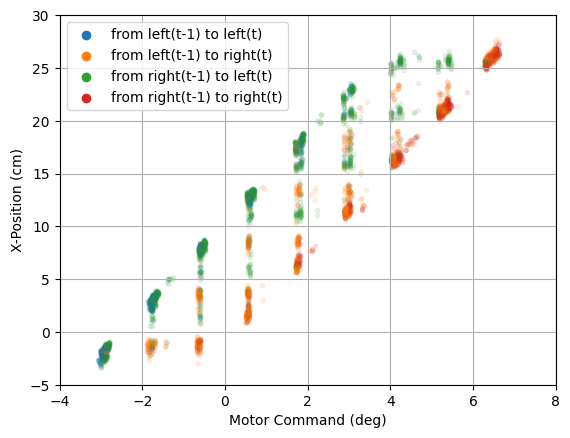

In [37]:
plt.scatter(-100, -100, color=colors[0])
plt.scatter(-100, -100, color=colors[1])
plt.scatter(-100, -100, color=colors[2])
plt.scatter(-100, -100, color=colors[3])

for i in range(len(filt_df)):
    idx = filt_df['phi_direction_left_pan'][i]
    plt.scatter(filt_df['theta_l_pan_cmd'][i], 100*filt_df['gazepoint_x'][i], marker='.', alpha=0.1, color=colors[idx])

plt.xlabel('Motor Command (deg)')
plt.ylabel('X-Position (cm)')
plt.legend(['from left(t-1) to left(t)','from left(t-1) to right(t)','from right(t-1) to left(t)','from right(t-1) to right(t)'])
plt.ylim([-5, 30])
plt.xlim([-4, 8])
plt.grid()